# This notebook created for solving Kaggle competition: https://www.kaggle.com/c/roscosmos-rucode/overview

## Data - satellite images in format .tif
## There are some instruments for working with tif format, but rasterio is the easiest to install: https://rasterio.readthedocs.io/en/latest/quickstart.html

### Downloading data and visualisation of test image

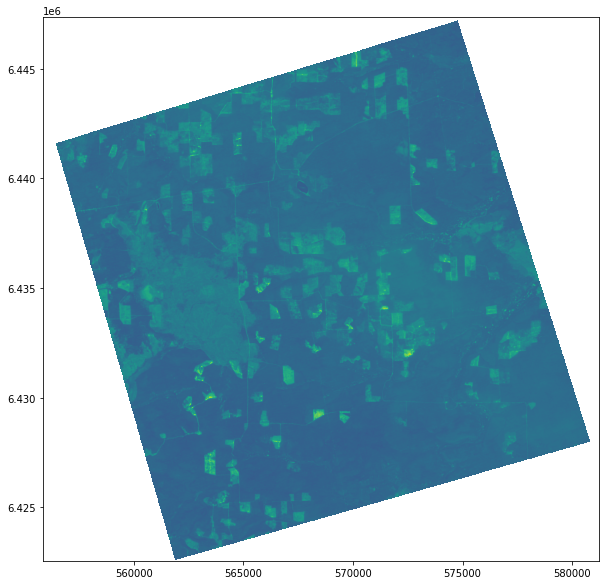

Number of image channels 8


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import tqdm
from tqdm import tqdm
import cv2 as cv
import rasterio
from rasterio.plot import show
import scipy as sp
import collections
from skimage.metrics import structural_similarity as ssim
from skimage.data import page
from skimage.filters import (threshold_otsu, threshold_niblack,
                             threshold_sauvola)
from scipy import stats, optimize, interpolate
import argparse
import sys

sys.path.append('/home/masha/Kaggle/RosCosmos_Kaggle/Code/')

import script
from script import mask_final_dict
from script import all_files


plt.rcParams["figure.figsize"] = (15,10)


path = '/home/masha/Kaggle/roscosmos-rucode/Images_composit/Images_composit/8_ch/'
input_files = glob.glob(path + '*.tif')

path_masks = '/home/masha/Kaggle/roscosmos-rucode/mask/mask/'
input_masks = glob.glob(path_masks + '*.tif')

ex = r'KV1_20180615_SCN4_UN37__KV3_20200522_SCN4_UN38.tif'


img = rasterio.open(path + ex)
show(img)
print('Number of image channels', img.count) # количество каналов

files_validation = []
masks_validation = []
masks_test = []
files_test = []
for f in input_files:
    name = path_masks + f.split('/')[-1]
    if name in input_masks:
        files_validation.append(f)
        masks_validation.append(name)
    else:
        files_test.append(f)
        masks_test.append(f)

### The first 4 channels are R G B I in the first image and R G B I in the second image

# I chose computer vision unsupervised algorithm SIFT for the backbone of the solution.

## In my decision, I rely on the article where was used approach is based on the SIFT algorithm and an a contrario approach. It can deal with multi-resolutions, multi-sensors and multi-incidence angles situations, and it offers promising results.https://ieeexplore.ieee.org/document/6946667

In [12]:
all_photo1_val, all_photo2_val = all_files(files_validation)

0it [00:00, ?it/s]

SSIM: 0.7840320564044985


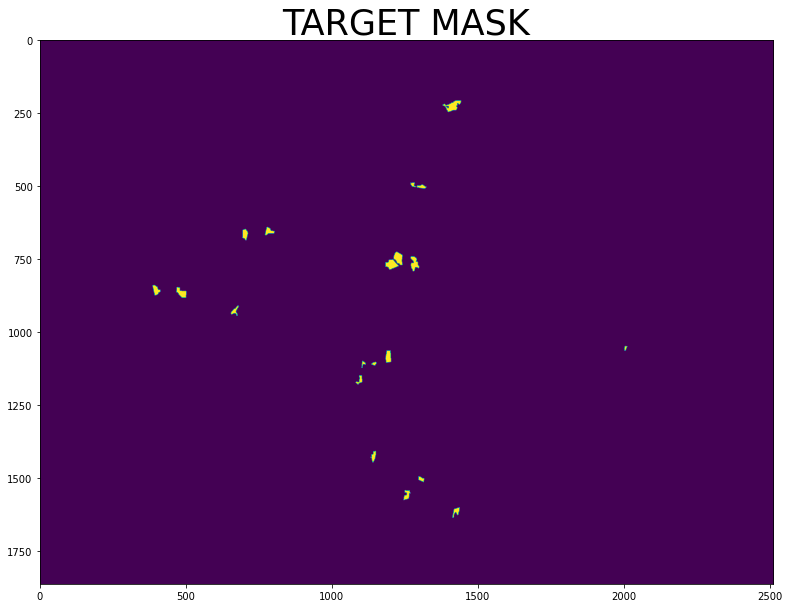

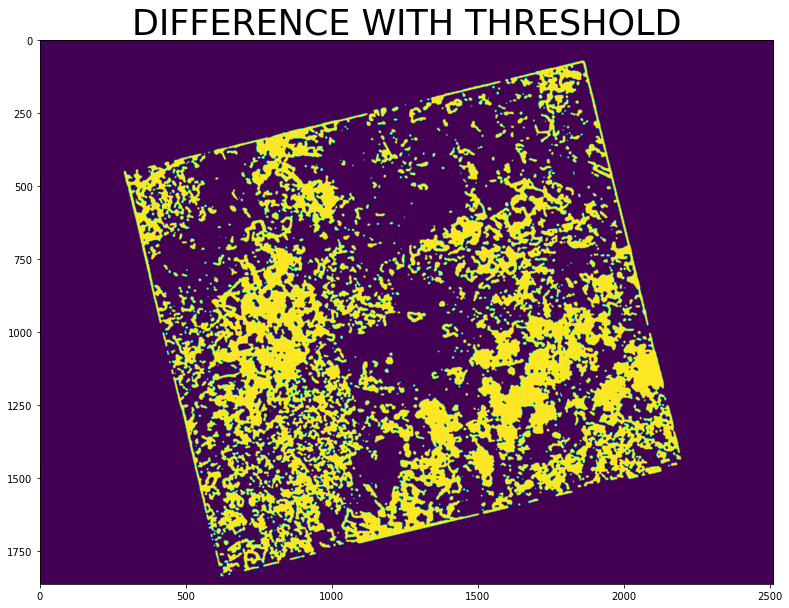

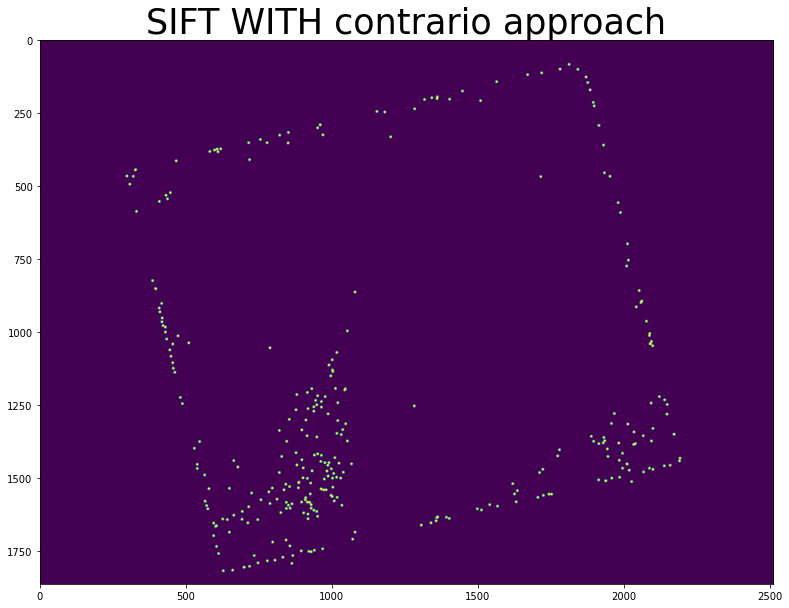

1it [00:21, 21.05s/it]

SSIM: 0.9564512180921216


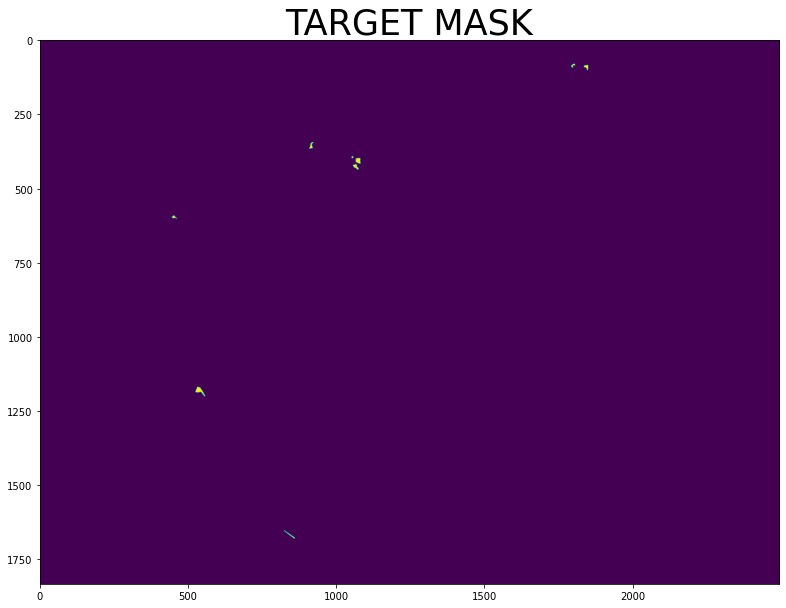

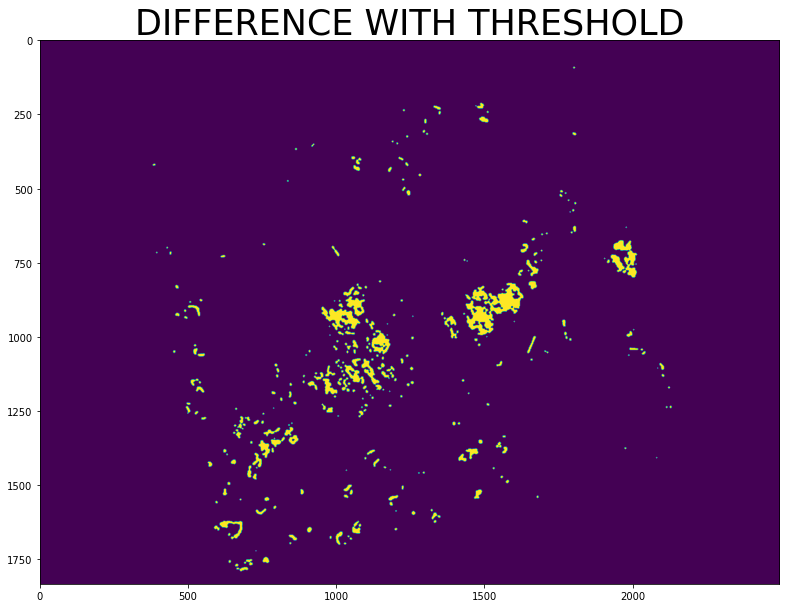

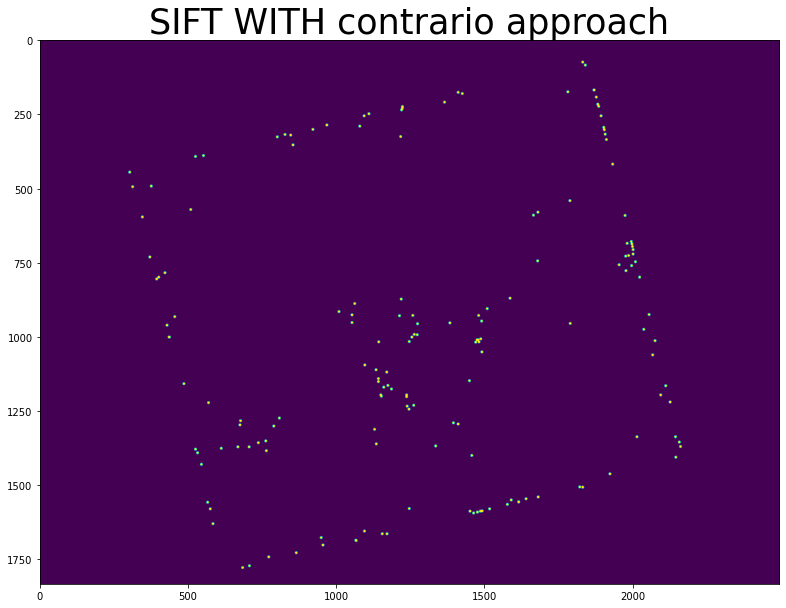

2it [00:33, 16.23s/it]

SSIM: 0.8981892551862275


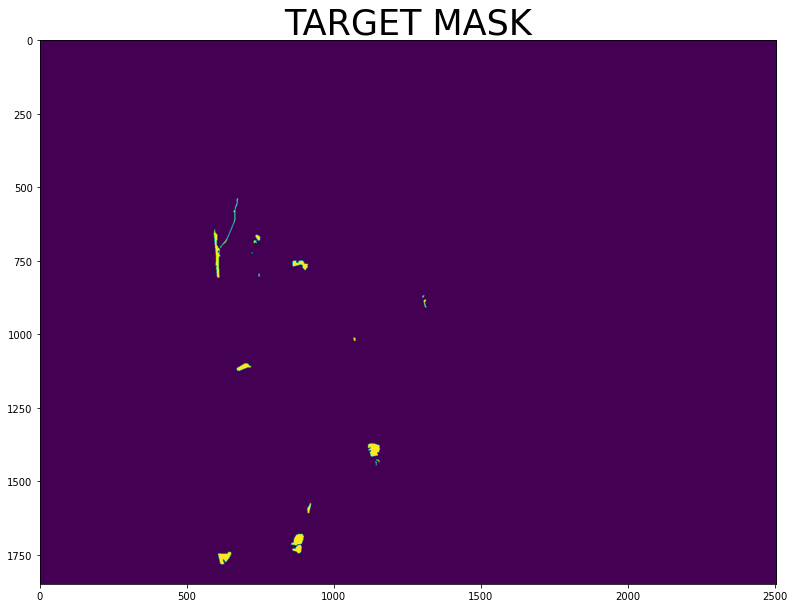

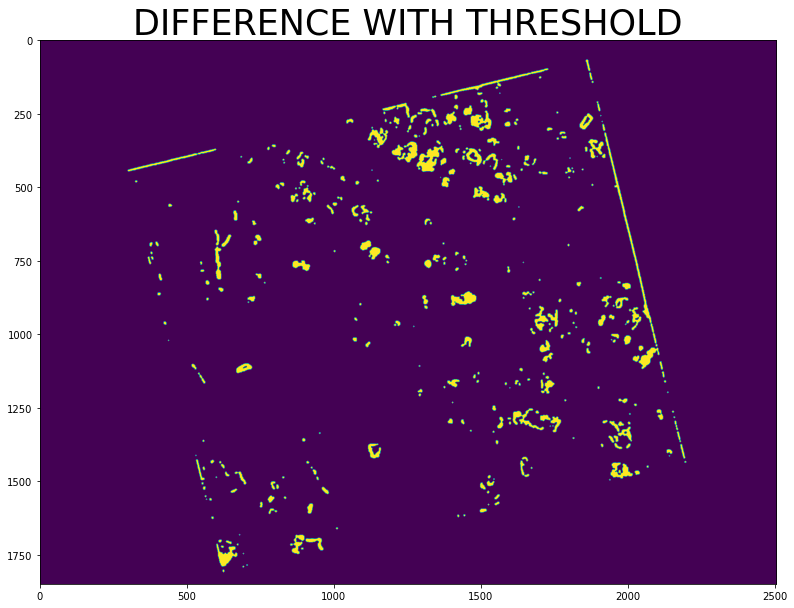

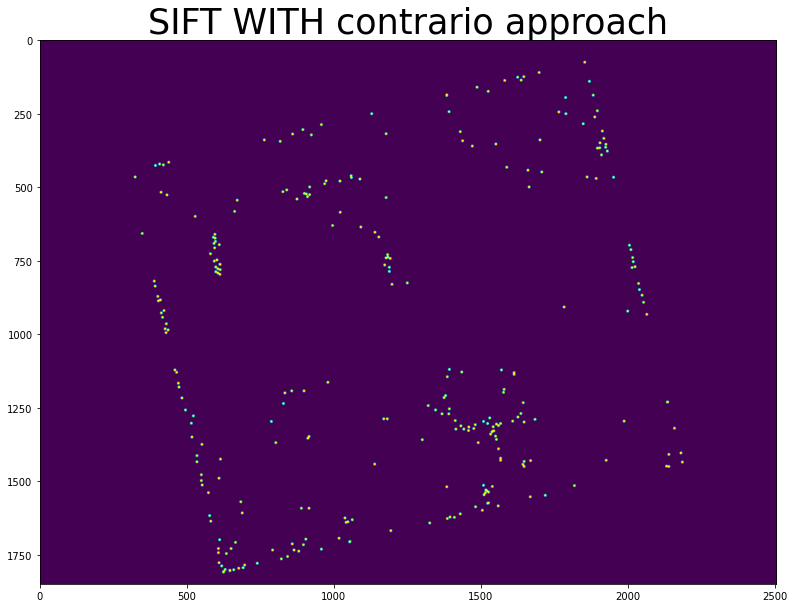

3it [00:54, 18.04s/it]

SSIM: 0.9206228899451029


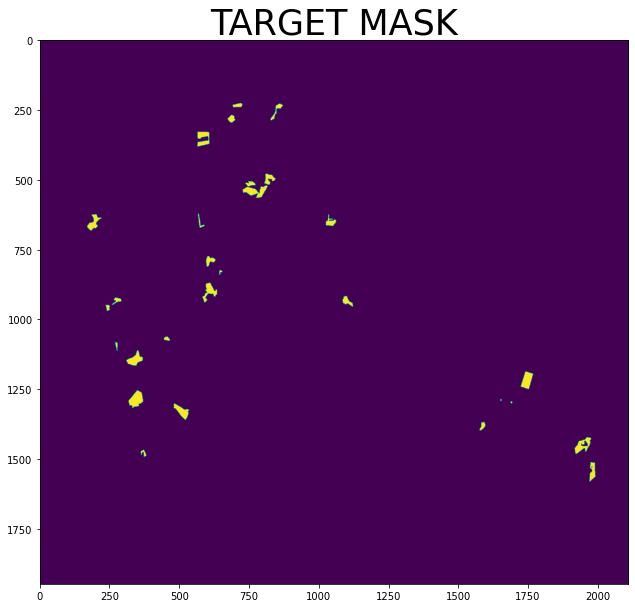

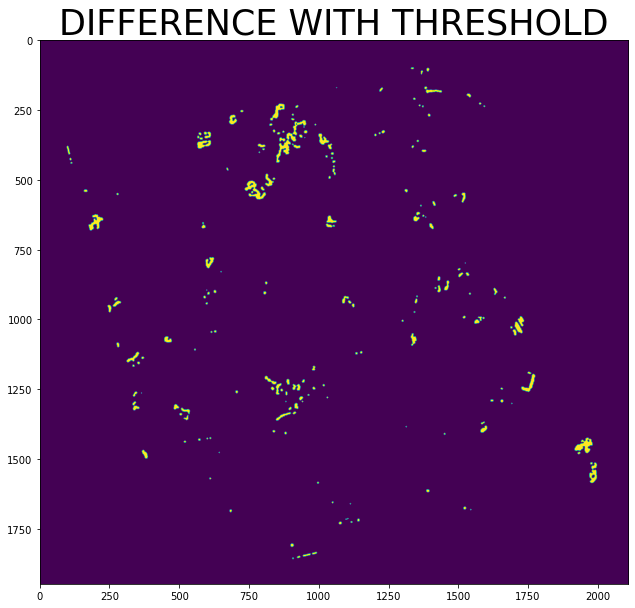

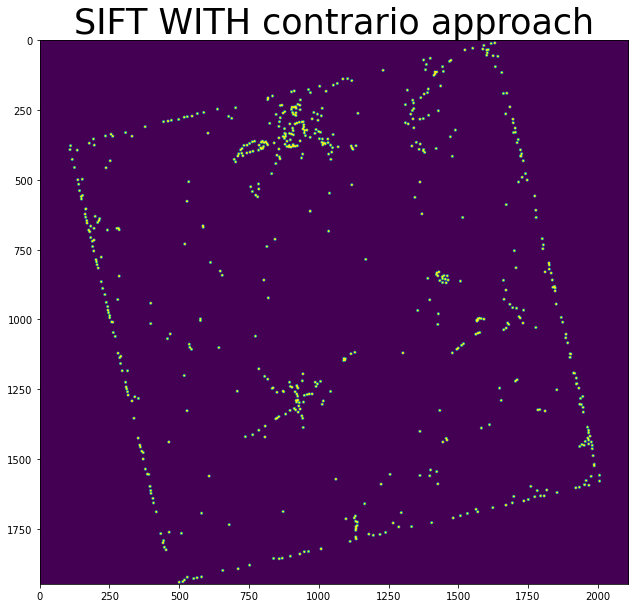

4it [01:24, 23.02s/it]

SSIM: 0.9580181322465186


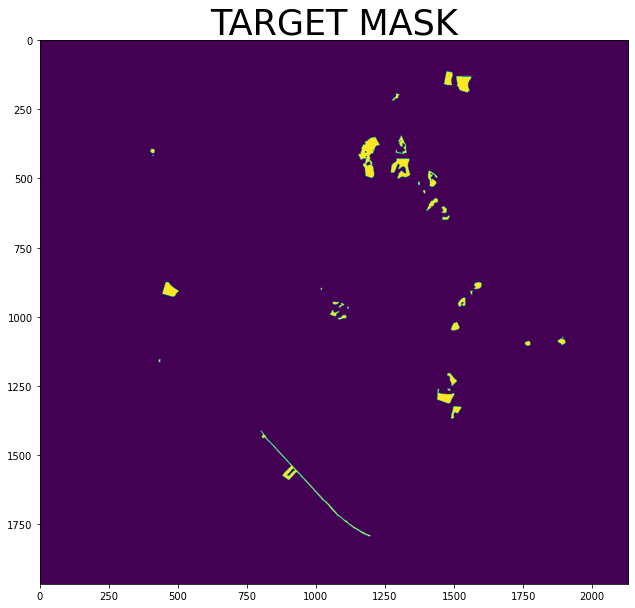

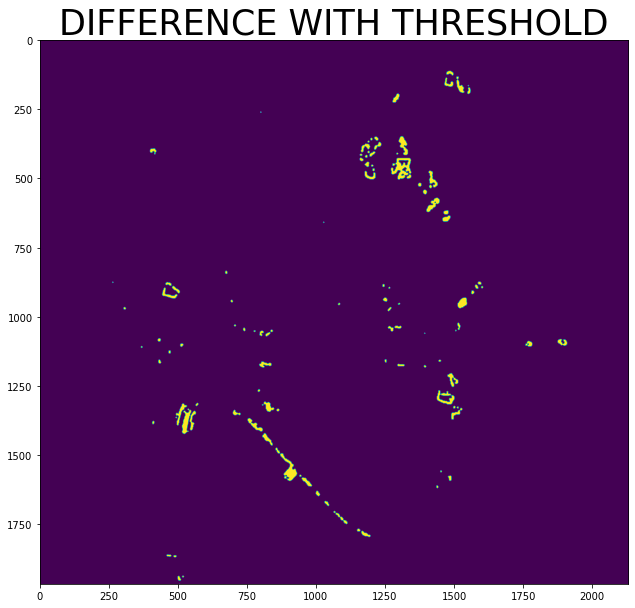

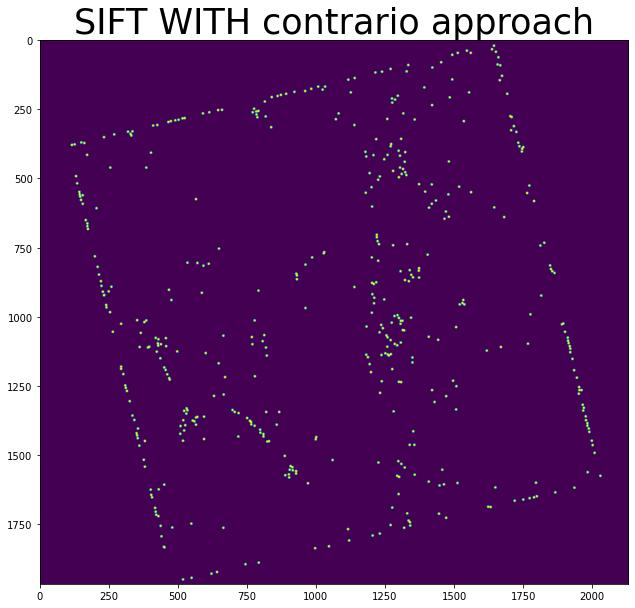

5it [01:51, 22.22s/it]


In [15]:
for img1, img2, mask in tqdm(zip(all_photo1_val, all_photo2_val, masks_validation)):
    end1 = mask_final_dict(img1, img2, 5, 1e-5)
# Compute SSIM between two images
    (score, diff) = ssim(img1, img2, full=True)
    print("SSIM: {}".format(score))
    target = rasterio.open(mask).read(1)

    kernel = np.ones((2, 2), 'uint8')
    diff[abs(diff) >= 0.99] = 1 
    diff = 1 - diff
    diff = diff - np.min(diff)
    diff = diff / np.max(diff)

    kernel2 = np.ones((3, 3), 'uint8')

    def porog(diff, low, up):
        maxd = np.max(diff)
        diff[diff<low*maxd] = 0
        diff[diff>up*maxd] = 0

        if len(diff[diff != 0]) > np.round(0.15*diff.shape[0]*diff.shape[1]):
            maxd = np.max(diff)
            diff[diff<low*maxd] = 0
            diff[diff>up*maxd] = 0
        else:
            return diff
        
    diff = porog(diff, 0.29, 0.51)   

        
    diff[diff != 0] = 1
    diff = np.round(diff).astype(np.uint8)
    diff = cv.GaussianBlur(diff,(5,5), 5)
    diff = cv.GaussianBlur(diff,(5,5), 6)

    
    
    diff = cv.dilate(diff, kernel, iterations=4)
    diff = cv.GaussianBlur(diff,(5,5), 5)

    diff = cv.erode(diff, kernel,iterations = 1)
    plt.title('TARGET MASK', size = 35)
    plt.imshow(target)
    plt.show()
    plt.title('DIFFERENCE WITH THRESHOLD', size = 35)
    plt.imshow(diff)
    plt.show()
    plt.title('SIFT WITH contrario approach', size = 35)
    plt.imshow(end1)
    plt.show()
